# Dataset Creation 2
In this notebook I take the test split of the previously parsed documents, and apply the reduction methods outlined in the paper. I then generate the summaries and ROUGE scores that are used in the analysis. Additionally, I do some exploratory EDA, and visualization.

In [ ]:
!pip install -q datasets transformers[sentencepiece]

     |████████████████████████████████| 365 kB 8.3 MB/s 
     |████████████████████████████████| 4.4 MB 77.5 MB/s 
     |████████████████████████████████| 212 kB 68.3 MB/s 
     |████████████████████████████████| 140 kB 75.2 MB/s 
     |████████████████████████████████| 101 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 80.8 MB/s 
     |████████████████████████████████| 596 kB 84.5 MB/s 
     |████████████████████████████████| 127 kB 76.2 MB/s 
     |████████████████████████████████| 144 kB 95.8 MB/s 
     |████████████████████████████████| 271 kB 79.3 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 62.3 MB/s 
     |████████████████████████████████| 1.2 MB 83.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=41060af25ada88d21a855acd9e8ab59eb82ffb04487336047411c66d038b9492
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


load the sentence parsed data

In [ ]:
from datasets import load_dataset
from tqdm.auto import tqdm

In [ ]:
dataset = load_dataset("nschantz21/cnn_dailymail-parsed", split="test")

Downloading:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

Using custom data configuration nschantz21--cnn_dailymail-parsed-fe40cf9fcda2d553


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nschantz21___parquet/nschantz21--cnn_dailymail-parsed-fe40cf9fcda2d553/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


load the distill bart model

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", tokenizer="sshleifer/distilbart-cnn-12-6", device=0)

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
len(dataset["article"])

11490

generate the baseline summaries

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset

In [ ]:
out_list = []
for out in tqdm(summarizer(KeyDataset(dataset, "article"), batch_size=32, min_length=5, max_length=512, truncation=True), total=len(dataset)):
    out_list.append(out)
base_summaries = pd.Series(out_list)
bs = list(map(lambda x: x[0]["summary_text"], base_summaries))
pd.Series(bs).to_csv("distill-bart-baselines.csv")

# Rouge
calculate the rouge scores for the summaries

In [ ]:
import matplotlib as plt

In [ ]:
import pandas as pd

In [ ]:
from datasets import load_metric
rouge_score = load_metric("rouge")

In [ ]:
scores = rouge_score.compute(predictions=bs, references=dataset["highlights"])

In [ ]:
scores

{'rouge1': AggregateScore(low=Score(precision=0.3851584381474419, recall=0.5081560807576829, fmeasure=0.4278656985453847), mid=Score(precision=0.3876910091296212, recall=0.5108643349509923, fmeasure=0.4300919786419507), high=Score(precision=0.3900958002361866, recall=0.5134287237474422, fmeasure=0.43227786606848523)),
 'rouge2': AggregateScore(low=Score(precision=0.18566042061541904, recall=0.24407325766466603, fmeasure=0.20570505033051686), mid=Score(precision=0.1879275267609807, recall=0.24703898194187068, fmeasure=0.20808396011615599), high=Score(precision=0.19011413423073764, recall=0.2497388951741669, fmeasure=0.21047607378843086)),
 'rougeL': AggregateScore(low=Score(precision=0.2670077710834573, recall=0.35310771508524486, fmeasure=0.29679206129553803), mid=Score(precision=0.2692344061537463, recall=0.3559400843397498, fmeasure=0.2990478206030961), high=Score(precision=0.27157499459353407, recall=0.3587273644068212, fmeasure=0.30131403059348644)),
 'rougeLsum': AggregateScore(lo

In [ ]:
scores["rouge2"].mid

Score(precision=0.1879275267609807, recall=0.24703898194187068, fmeasure=0.20808396011615599)

In [ ]:
scores["rougeL"].mid

Score(precision=0.2692344061537463, recall=0.3559400843397498, fmeasure=0.2990478206030961)

# Baseline2
Using the lead 3 as a secondary baseline.  
Requires basically no preprocessing.  
It gets pretty close to the baseline summarization, based on the rouge metrics

In [ ]:
lead3 = list(map(lambda x: " ".join(x[:min(3, len(x))]), dataset["article_sent"]))

In [ ]:
scores_lead3 = rouge_score.compute(predictions=lead3, references=dataset["highlights"])

In [ ]:
scores_lead3["rouge2"].mid

Score(precision=0.14544466029581832, recall=0.22348551918173926, fmeasure=0.17002546529448398)

In [ ]:
scores_lead3["rougeL"].mid

Score(precision=0.2087901364938311, recall=0.3217366021291256, fmeasure=0.24437163971120762)

In [ ]:
scores_long = rouge_score.compute(predictions=bs, references=dataset["highlights"], use_aggregator=False)

In [ ]:
r2fm = list(map(lambda x: x.fmeasure, scores_long["rouge2"]))

In [ ]:
article_word_len = list(map(lambda x: len(x.split(" ")), dataset["article"]))

In [ ]:
token_len = list(map(len, summarizer.tokenizer(dataset["article"])["input_ids"]))

In [ ]:
len_comp = pd.DataFrame({"article_len":article_word_len, "token_len": token_len, "rouge2": r2fm})
len_comp["rouge2"] = len_comp["rouge2"] * 100

Based on the distillbart tokenizer, you can basically take up to 750 words before you hit a limit of 1024 tokens.

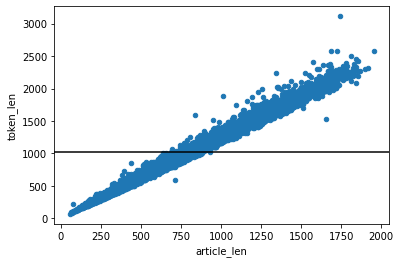

In [ ]:
ax = len_comp.plot(kind="scatter", x=0, y=1)
ax.axhline(1024, color='k')

In [ ]:
len_comp.describe()

,article_len,token_len,rouge2,sent_wrd_len
count,11490.000000,11490.000000,11490.000000,11490.000000
mean,682.859356,858.563969,20.808305,21.177011
std,348.230026,440.230117,12.942063,3.726346
min,55.000000,66.000000,0.000000,4.277778
25%,418.250000,524.000000,11.681202,18.787395
50%,613.000000,772.000000,18.666667,21.108402
75%,875.000000,1095.000000,27.536232,23.476190
max,1954.000000,3112.000000,100.000000,47.500000


there appears to be a somewhat negative relationship between rouge scores and article lengths

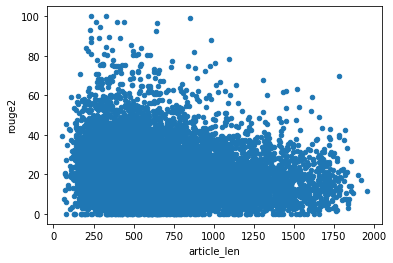

In [ ]:
ax = len_comp.plot(kind="scatter", x=0, y=2)

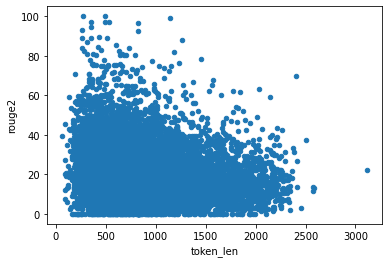

In [ ]:
ax = len_comp.plot(kind="scatter", x=1, y=2)

Most of the articles are less than 750 words

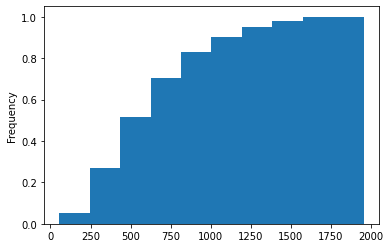

In [ ]:
ax = len_comp["article_len"].plot(kind="hist", cumulative=True, density=1)

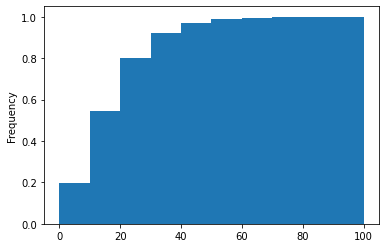

In [ ]:
ax = len_comp["rouge2"].plot(kind="hist", cumulative=True, density=1)

# Article Sentence Length
I need to determine the avg sentence length across the dataset so that I can decide how many sentences I can include in the reduced sets

In [ ]:
from functools import reduce

In [ ]:
# what is the average length of a sentence in words across the dataset
def avg_words_in_sent(sents):
    "sents is a list of list of words"
    word_cnt = list(map(len, sents))
    return reduce(lambda x, y: x + y, word_cnt) / len(sents)

In [ ]:
avg_sent_lent_words = list(map(avg_words_in_sent, dataset["article_sent_words"]))

In [ ]:
len_comp["sent_wrd_len"] = avg_sent_lent_words

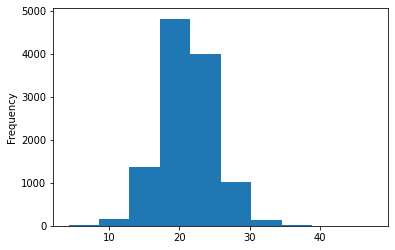

In [ ]:
len_comp["sent_wrd_len"].plot(kind="hist")

There is no relationship between article avg sentence length and any of the other metrics

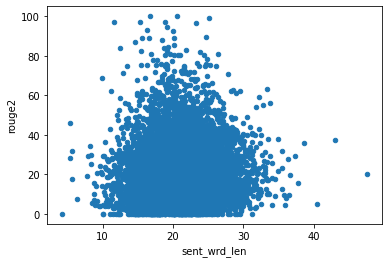

In [ ]:
len_comp.plot(kind="scatter", x="sent_wrd_len", y="rouge2")

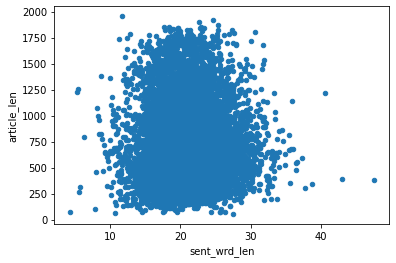

In [ ]:
len_comp.plot(kind="scatter", x="sent_wrd_len", y="article_len")

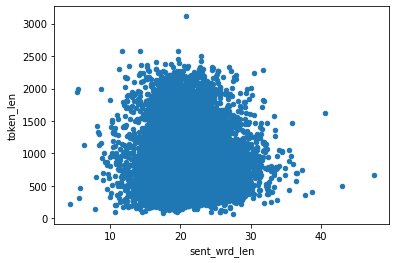

In [ ]:
len_comp.plot(kind="scatter", x="sent_wrd_len", y="token_len")

In [ ]:
num_of_sents = pd.Series(list(map(len, dataset["article_sent"])))

In [ ]:
num_of_sents.describe()

count    11490.000000
mean        33.341340
std         18.931519
min          2.000000
25%         20.000000
50%         29.000000
75%         42.000000
max        231.000000
dtype: float64

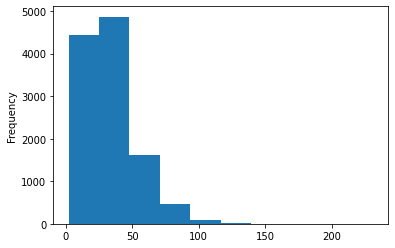

In [ ]:
num_of_sents.plot(kind="hist")

It appears there are about 30 sentences in an article on average

# Reduction Methods
I will apply each of these methods to the sentence-split articles
1. Everyother sentence
2. Begin, Middle, End of sentence
4. Random Sample of sentences

## Make the datasets

Every other sentence

In [ ]:
new_dataset = dataset.map(lambda x: {"everyother": " ".join(x["article_sent"][::2])}, num_proc=8)

#0:   0%|          | 0/1437 [00:00<?, ?ex/s]

#2:   0%|          | 0/1436 [00:00<?, ?ex/s]

#1:   0%|          | 0/1437 [00:00<?, ?ex/s]

#3:   0%|          | 0/1436 [00:00<?, ?ex/s]

#4:   0%|          | 0/1436 [00:00<?, ?ex/s]

#5:   0%|          | 0/1436 [00:00<?, ?ex/s]

#6:   0%|          | 0/1436 [00:00<?, ?ex/s]

#7:   0%|          | 0/1436 [00:00<?, ?ex/s]

random 50% of sentences

In [ ]:
from random import sample

In [ ]:
# get a random sample, reducing length by half - order doesn't matter
new_dataset = new_dataset.map(lambda x: {"random_sent": " ".join(sample(x["article_sent"], min(15, len(x["article_sent"]))))}, num_proc=8)

#1:   0%|          | 0/1437 [00:00<?, ?ex/s]

#0:   0%|          | 0/1437 [00:00<?, ?ex/s]

#2:   0%|          | 0/1436 [00:00<?, ?ex/s]

#3:   0%|          | 0/1436 [00:00<?, ?ex/s]

#4:   0%|          | 0/1436 [00:00<?, ?ex/s]

#7:   0%|          | 0/1436 [00:00<?, ?ex/s]

#5:   0%|          | 0/1436 [00:00<?, ?ex/s]

#6:   0%|          | 0/1436 [00:00<?, ?ex/s]

Create the summaries

In [ ]:
every_other_out_list = []
for out in tqdm(summarizer(KeyDataset(new_dataset, "everyother"), batch_size=32, min_length=5, max_length=512, truncation=True), total=len(dataset)):
    every_other_out_list.append(out)

  0%|          | 0/11490 [00:00<?, ?it/s]

Your max_length is set to 512, but you input_length is only 509. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=254)


In [ ]:
everyother_summaries = pd.Series(every_other_out_list)
eos = list(map(lambda x: x[0]["summary_text"], everyother_summaries))

In [ ]:
pd.Series(eos).to_csv("dsbart-everyother.csv")

In [ ]:
scores_eo_agg = rouge_score.compute(predictions=eos, references=dataset["highlights"])

In [ ]:
scores_eo_agg["rouge2"].mid.fmeasure*100

16.449699101445784

In [ ]:
scores_eo_agg["rougeL"].mid.fmeasure*100

25.981765308798888

Random selection

In [ ]:
random_sent_out_list = []
for out in tqdm(summarizer(KeyDataset(new_dataset, "random_sent"), batch_size=32, min_length=5, max_length=512, truncation=True), total=len(dataset)):
    random_sent_out_list.append(out)
random_summaries = pd.Series(random_sent_out_list)
rsum = list(map(lambda x: x[0]["summary_text"], random_summaries))
pd.Series(rsum).to_csv("dsbart-random.csv")

  0%|          | 0/11490 [00:00<?, ?it/s]

Your max_length is set to 512, but you input_length is only 451. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=225)
Your max_length is set to 512, but you input_length is only 471. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=235)
Your max_length is set to 512, but you input_length is only 443. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=221)
Your max_length is set to 512, but you input_length is only 486. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=243)
Your max_length is set to 512, but you input_length is only 467. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=233)
Your max_length is set to 512, but you input_length is only 499. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=249)
Your max_length is set to 512, but you input_length is only 464. You m

Calculate the rouge score for the random sample

In [ ]:
scores_rsum_agg = rouge_score.compute(predictions=rsum, references=dataset["highlights"])

In [ ]:
scores_rsum_agg["rouge2"].mid.fmeasure

0.152505142709486

In [ ]:
scores_rsum_agg["rougeL"].mid.fmeasure

0.2457304584716153

# Begin Middle End

In [ ]:
# the summaries are roughly 50 words long
pd.Series(list(map(lambda x: len(x.split(" ")), new_dataset["highlights"]))).describe()

count    11490.000000
mean        51.883551
std         21.409787
min          9.000000
25%         38.000000
50%         48.000000
75%         60.000000
max        535.000000
dtype: float64

In [ ]:
def begmidend(sents, pct=.5):
    """
    This function takes the `pct` percent of the article by number of sentences 
    and evenly samples from the beginning, middle, and end of the article,
    maintaining sentence order
    """
    sl = len(sents)
    K = int(sl * pct) // 3
    strt_idx = (sl // 2) - (K // 2)
    end_idx = (sl // 2) + (K // 2)

    return " ".join(sents[:K+1] + sents[strt_idx: end_idx + 1] + sents[-K:])

In [ ]:
# get 50% of sentences evenly from beginning middle and end
new_dataset = new_dataset.map(lambda x: {"beg_mid_end": begmidend(x["article_sent"])}, num_proc=8)

#0:   0%|          | 0/1437 [00:00<?, ?ex/s]

#2:   0%|          | 0/1436 [00:00<?, ?ex/s]

#1:   0%|          | 0/1437 [00:00<?, ?ex/s]

#3:   0%|          | 0/1436 [00:00<?, ?ex/s]

#4:   0%|          | 0/1436 [00:00<?, ?ex/s]

#5:   0%|          | 0/1436 [00:00<?, ?ex/s]

#7:   0%|          | 0/1436 [00:00<?, ?ex/s]

#6:   0%|          | 0/1436 [00:00<?, ?ex/s]

In [ ]:
bme_out_list = []
for out in tqdm(summarizer(KeyDataset(new_dataset, "beg_mid_end"), batch_size=32, min_length=5, max_length=512, truncation=True), total=len(dataset)):
    bme_out_list.append(out)

  0%|          | 0/11490 [00:00<?, ?it/s]

Your max_length is set to 512, but you input_length is only 504. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=252)


In [ ]:
bme_summaries = pd.Series(bme_out_list)
bme_sum = list(map(lambda x: x[0]["summary_text"], bme_summaries))
pd.Series(bme_sum).to_csv("dsbart-bme.csv")

In [ ]:
scores_bmesum_agg = rouge_score.compute(predictions=bme_sum, references=dataset["highlights"])

wow pretty good!

In [ ]:
scores_bmesum_agg["rouge2"].mid.fmeasure

0.1935081533674649

In [ ]:
scores_bmesum_agg["rougeL"].mid.fmeasure

0.28779114925255234

# Begin Middle End
get reduced documents using the Beginning Middle End algo for 75% and 25% of original doc length. Then generate the summaries and check out the rouge scores

In [ ]:
# get 75% of sentences evenly from beginning middle and end
new_dataset = new_dataset.map(lambda x: {"beg_mid_end75": begmidend(x["article_sent"], .75)}, num_proc=8)

#0:   0%|          | 0/1437 [00:00<?, ?ex/s]

#1:   0%|          | 0/1437 [00:00<?, ?ex/s]

#2:   0%|          | 0/1436 [00:00<?, ?ex/s]

#3:   0%|          | 0/1436 [00:00<?, ?ex/s]

#4:   0%|          | 0/1436 [00:00<?, ?ex/s]

#5:   0%|          | 0/1436 [00:00<?, ?ex/s]

#6:   0%|          | 0/1436 [00:00<?, ?ex/s]

#7:   0%|          | 0/1436 [00:00<?, ?ex/s]

In [ ]:
new_dataset = new_dataset.map(lambda x: {"beg_mid_end25": begmidend(x["article_sent"], .25)}, num_proc=8)

#0:   0%|          | 0/1437 [00:00<?, ?ex/s]

#1:   0%|          | 0/1437 [00:00<?, ?ex/s]

#2:   0%|          | 0/1436 [00:00<?, ?ex/s]

#4:   0%|          | 0/1436 [00:00<?, ?ex/s]

#3:   0%|          | 0/1436 [00:00<?, ?ex/s]

#5:   0%|          | 0/1436 [00:00<?, ?ex/s]

#6:   0%|          | 0/1436 [00:00<?, ?ex/s]

#7:   0%|          | 0/1436 [00:00<?, ?ex/s]

In [ ]:
bme25_out_list = []
for out in tqdm(summarizer(KeyDataset(new_dataset, "beg_mid_end25"), batch_size=32, min_length=5, max_length=512, truncation=True), total=len(dataset)):
    bme25_out_list.append(out)

Your max_length is set to 512, but you input_length is only 485. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=242)
Your max_length is set to 512, but you input_length is only 440. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=220)
Your max_length is set to 512, but you input_length is only 478. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=239)
Your max_length is set to 512, but you input_length is only 447. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=223)
Your max_length is set to 512, but you input_length is only 480. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=240)
Your max_length is set to 512, but you input_length is only 400. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=200)
Your max_length is set to 512, but you input_length is only 501. You m

In [ ]:
bme25_summaries = pd.Series(bme25_out_list)
bme25_sum = list(map(lambda x: x[0]["summary_text"], bme25_summaries))
pd.Series(bme25_sum).to_csv("dsbart-bme25.csv")

In [ ]:
scores_bmesum25_agg = rouge_score.compute(predictions=bme25_sum, references=dataset["highlights"])

In [ ]:
scores_bmesum25_agg["rouge2"].mid.fmeasure

0.16702898130790136

In [ ]:
scores_bmesum25_agg["rougeL"].mid.fmeasure

0.26445809676062126

75% of the article length

In [ ]:
bme75_out_list = []
for out in tqdm(summarizer(KeyDataset(new_dataset, "beg_mid_end75"), batch_size=32, min_length=5, max_length=512, truncation=True), total=len(dataset)):
    bme75_out_list.append(out)

  0%|          | 0/11490 [00:00<?, ?it/s]

In [ ]:
bme75_summaries = pd.Series(bme75_out_list)
bme75_sum = list(map(lambda x: x[0]["summary_text"], bme75_summaries))
pd.Series(bme75_sum).to_csv("dsbart-bme75.csv")

In [ ]:
scores_bmesum75_agg = rouge_score.compute(predictions=bme75_sum, references=dataset["highlights"])

In [ ]:
scores_bmesum75_agg["rouge2"].mid.fmeasure

0.2035500787917064

In [ ]:
scores_bmesum75_agg["rougeL"].mid.fmeasure

0.29608176447955875

# Save the dataset

In [ ]:
#from huggingface_hub import notebook_login
#notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
#new_dataset.push_to_hub("nschantz21/cnn_dailymail-parsed-processed", private=False)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1951: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  FutureWarning,


# Hardware Specs

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-81b67f07-a9c5-9689-308d-53cfe938cfb5)


In [ ]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Wed Jul 27 00:05:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |  15997MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

Socket(s):           1


In [ ]:
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

Core(s) per socket:  2


In [ ]:
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

Thread(s) per core:  2


In [ ]:
!lscpu | grep "L3 cache" 

L3 cache:            56320K


In [ ]:
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at shown frequency
!lscpu | grep "MHz"

CPU MHz:             2199.998


In [ ]:
#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

26G


In [ ]:
#hard disk space that we can use
!df -h / | awk '{print $4}'

Avail
119G
